In [99]:
import pandas as pd                 #Imports pandas as pd
import numpy as np                  #Imports numpy as np
import matplotlib.pyplot as plt     # Imports matplotlib.pyplot as plt
import seaborn as sns               #Imports seaborn as sns
import descartes
import geopandas as gpd
import shapefile as shp
from sklearn import decomposition
from shapely.geometry import Point, Polygon
fp = pd.read_csv("crime.csv")       # Reads the file named "crime.csv"
crime=pd.DataFrame()                #Converting to dataFrame
crime=fp

In [100]:
print(crime.head())                 #Prints the dataset

          TYPE  YEAR  MONTH  DAY  HOUR  MINUTE     HUNDRED_BLOCK  \
0  Other Theft  2003      5   12  16.0    15.0  9XX TERMINAL AVE   
1  Other Theft  2003      5    7  15.0    20.0  9XX TERMINAL AVE   
2  Other Theft  2003      4   23  16.0    40.0  9XX TERMINAL AVE   
3  Other Theft  2003      4   20  11.0    15.0  9XX TERMINAL AVE   
4  Other Theft  2003      4   12  17.0    45.0  9XX TERMINAL AVE   

  NEIGHBOURHOOD         X           Y   Latitude   Longitude  
0    Strathcona  493906.5  5457452.47  49.269802 -123.083763  
1    Strathcona  493906.5  5457452.47  49.269802 -123.083763  
2    Strathcona  493906.5  5457452.47  49.269802 -123.083763  
3    Strathcona  493906.5  5457452.47  49.269802 -123.083763  
4    Strathcona  493906.5  5457452.47  49.269802 -123.083763  


In [101]:
#Check for the missing data
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530652 entries, 0 to 530651
Data columns (total 12 columns):
TYPE             530652 non-null object
YEAR             530652 non-null int64
MONTH            530652 non-null int64
DAY              530652 non-null int64
HOUR             476290 non-null float64
MINUTE           476290 non-null float64
HUNDRED_BLOCK    530639 non-null object
NEIGHBOURHOOD    474028 non-null object
X                530652 non-null float64
Y                530652 non-null float64
Latitude         530652 non-null float64
Longitude        530652 non-null float64
dtypes: float64(6), int64(3), object(3)
memory usage: 48.6+ MB


In [102]:
#Data preprocessing
#Check for the missing data
crime.isnull().sum()

TYPE                 0
YEAR                 0
MONTH                0
DAY                  0
HOUR             54362
MINUTE           54362
HUNDRED_BLOCK       13
NEIGHBOURHOOD    56624
X                    0
Y                    0
Latitude             0
Longitude            0
dtype: int64

In [103]:
#Data preprocessing
#Column MINUTE can be deleted as we don't need to go to the minute level. 
crime.drop(['MINUTE'],axis = 1,inplace=True)

In [104]:
#Data preprocessing
#We fill the missing values
crime['HOUR'].fillna(0,inplace = True)
crime['HUNDRED_BLOCK'].fillna('N/A',inplace=True)
crime['NEIGHBOURHOOD'].fillna('N/A',inplace = True)

In [105]:
crime['Incident'] = 1
crime['Date'] = pd.to_datetime({'year':crime['YEAR'], 'month':crime['MONTH'], 'day':crime['DAY']})
crime['DayOfWeek'] = crime['Date'].dt.weekday_name
crime.index = pd.DatetimeIndex(crime['Date'])
crime.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 530652 entries, 2003-05-12 to 2017-06-06
Data columns (total 14 columns):
TYPE             530652 non-null object
YEAR             530652 non-null int64
MONTH            530652 non-null int64
DAY              530652 non-null int64
HOUR             530652 non-null float64
HUNDRED_BLOCK    530652 non-null object
NEIGHBOURHOOD    530652 non-null object
X                530652 non-null float64
Y                530652 non-null float64
Latitude         530652 non-null float64
Longitude        530652 non-null float64
Incident         530652 non-null int64
Date             530652 non-null datetime64[ns]
DayOfWeek        530652 non-null object
dtypes: datetime64[ns](1), float64(5), int64(4), object(4)
memory usage: 60.7+ MB


In [106]:
crime['TYPE'].value_counts()    #Counts the number of crimes in each type

Theft from Vehicle                                        172700
Mischief                                                   70413
Break and Enter Residential/Other                          60862
Offence Against a Person                                   54142
Other Theft                                                52167
Theft of Vehicle                                           38418
Break and Enter Commercial                                 33845
Theft of Bicycle                                           25730
Vehicle Collision or Pedestrian Struck (with Injury)       21901
Vehicle Collision or Pedestrian Struck (with Fatality)       254
Homicide                                                     220
Name: TYPE, dtype: int64

From the types above, We create the following categories: Break and Enter, Theft, Vehicle Collision, Others

In [107]:
# Create a function to categorize types, using an 'if' statement.
def category(crime_type):
    if 'Theft' in crime_type:
        return 'Theft'
    elif 'Break' in crime_type:
        return 'Break and Enter'
    elif 'Collision' in crime_type:
        return 'Vehicle Collision'
    else:
        return 'Others'

In [108]:
# Apply the function and add it as CATEGORY column
crime['CATEGORY'] = crime['TYPE'].apply(category)

In [109]:
vehicle_collision = crime[crime['CATEGORY'] == 'Vehicle Collision']
crimes = crime[crime['CATEGORY'] != 'Vehicle Collision']
crimes.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 508497 entries, 2003-05-12 to 2017-06-05
Data columns (total 15 columns):
TYPE             508497 non-null object
YEAR             508497 non-null int64
MONTH            508497 non-null int64
DAY              508497 non-null int64
HOUR             508497 non-null float64
HUNDRED_BLOCK    508497 non-null object
NEIGHBOURHOOD    508497 non-null object
X                508497 non-null float64
Y                508497 non-null float64
Latitude         508497 non-null float64
Longitude        508497 non-null float64
Incident         508497 non-null int64
Date             508497 non-null datetime64[ns]
DayOfWeek        508497 non-null object
CATEGORY         508497 non-null object
dtypes: datetime64[ns](1), float64(5), int64(4), object(5)
memory usage: 62.1+ MB


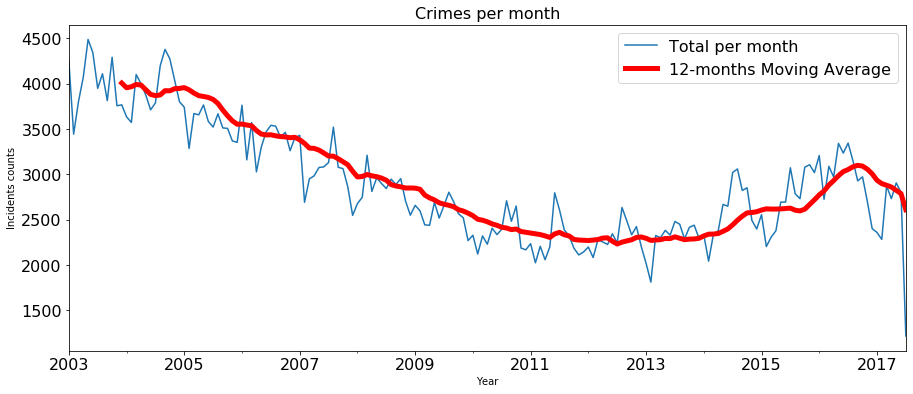

In [110]:
#Trend Analysis
# Using resample 'M' and rolling window 12
plt.figure(figsize=(15,6))
crimes.resample('M').size().plot(label='Total per month')
crimes.resample('M').size().rolling(window=12).mean().plot(color='red', linewidth=5, label='12-months Moving Average')

plt.title('Crimes per month', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Incidents counts')
plt.legend(prop={'size':16})
plt.tick_params(labelsize=16)

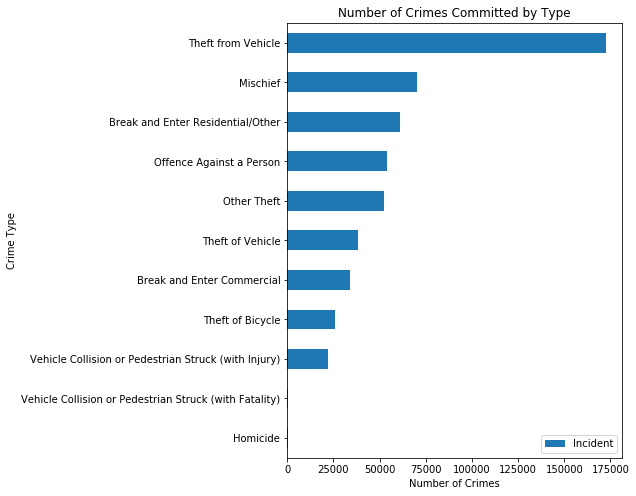

In [111]:
#We visualize the number of crimes committed by Type
%matplotlib inline
# Pivoting dataframe by Crime Type to calculate Number of Crimes
CrimeType = pd.pivot_table(crime, values=["Incident"],index = ["TYPE"],aggfunc='count')
CrimeType = CrimeType.sort_values(['Incident'], ascending=True)
# Create bar graph for number of crimes by Type of Crime
crimeplot = CrimeType.plot(kind='barh',figsize = (6,8),title='Number of Crimes Committed by Type')
plt.rcParams["figure.dpi"] = 200
plt.legend(loc='lower right')
plt.ylabel('Crime Type')
plt.xlabel('Number of Crimes')
plt.show(crimeplot)

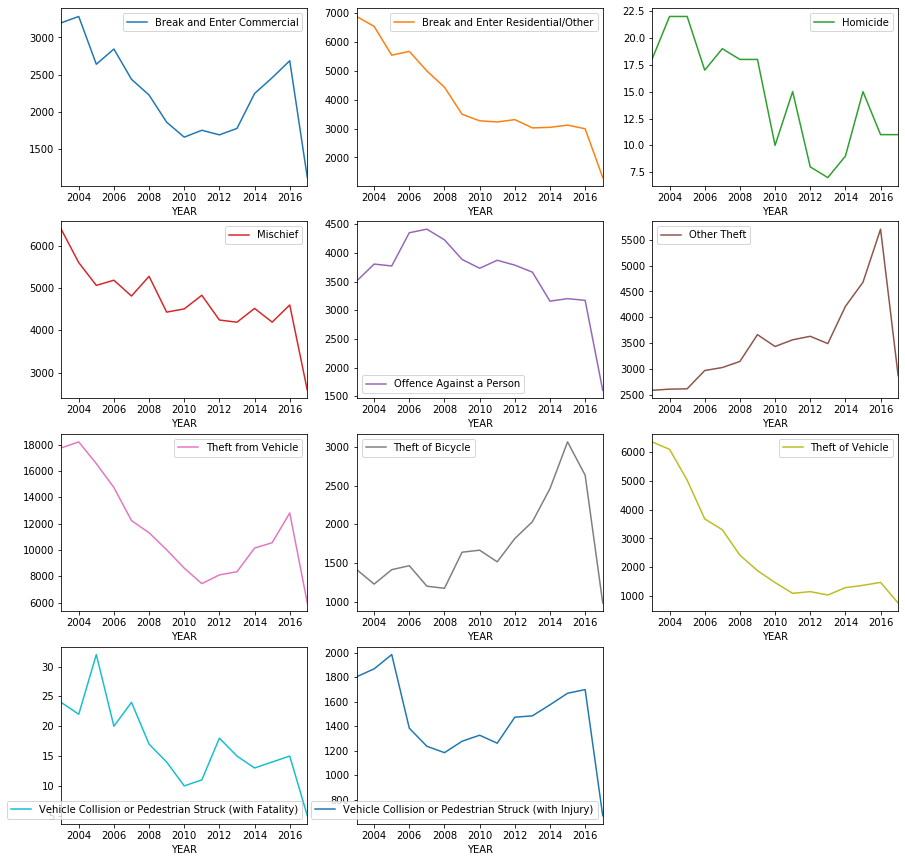

In [112]:
#Trend analysis of the dataset
%matplotlib inline
# Crime count by Category per year
CrimeDate = crime.pivot_table(values='Incident',aggfunc=np.size,columns='TYPE',index='YEAR',fill_value=0)
p= CrimeDate.plot(figsize=(15, 15), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

In [113]:
#Converting text labels to numbers
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
crime['TYPE'] = encoder.fit_transform(crime['TYPE'])

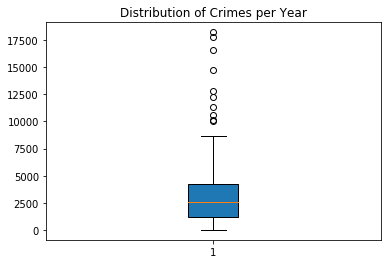

In [114]:
#statistical analysis of the dataset using BOX PLOTS
%matplotlib inline
YearType = pd.pivot_table(crime, values=["Incident"],index = ["YEAR", "TYPE"], aggfunc='count')
CrimeByYear = YearType.reset_index().sort_values(['YEAR','Incident'], ascending=[1,0]).set_index(["YEAR", "TYPE"])
# Plot data on box whiskers plot
NoOfCrimes = CrimeByYear["Incident"]
plt.boxplot(NoOfCrimes,notch=False, patch_artist=True)
plt.title("Distribution of Crimes per Year")
plt.show()

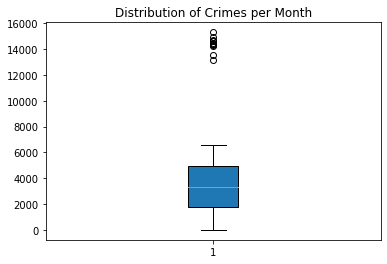

In [115]:
#statistical analysis of the dataset using BOX PLOTS
MonthType = pd.pivot_table(crime, values=["Incident"],index = ["MONTH","TYPE"],aggfunc='count')
CrimeByMonth = MonthType.reset_index().sort_values(['MONTH','Incident'], ascending=[1,0]).set_index(["MONTH", "TYPE"])
# Plot data on box whiskers plot
NoOfCrimes = CrimeByMonth["Incident"]
plt.boxplot(NoOfCrimes,patch_artist=True)
plt.title("Distribution of Crimes per Month")
plt.show()

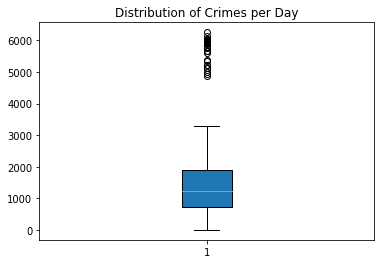

In [116]:
PivDayType = pd.pivot_table(crime, values=["Incident"],index = ["DAY", "TYPE"], aggfunc='count')
CrimeByDay = PivDayType.reset_index().sort_values(['DAY','Incident'], ascending=[1,0]).set_index(["DAY", "TYPE"])
# Plot data on box whiskers plot
NoOfCrimes = CrimeByDay["Incident"]
plt.boxplot(NoOfCrimes,patch_artist=True)
plt.title("Distribution of Crimes per Day")
plt.show()

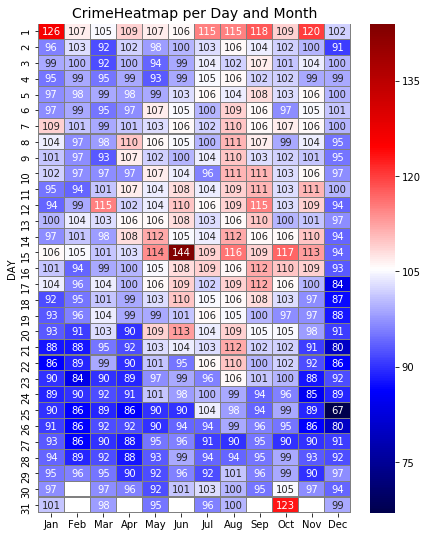

In [117]:
#Trend analysis of the data set using heatmaps
# Create a pivot table with day and month; another that counts the number of years that each day had; and the average. 
crimes_pivot_table = crime[(crime['Date'] != '2017-06-06')].pivot_table(values='YEAR', index='DAY', columns='MONTH', aggfunc=len)
crimes_pivot_table_year_count = crime[(crime['Date'] != '2017-06-06')].pivot_table(values='YEAR', index='DAY', columns='MONTH', aggfunc=lambda x: len(x.unique()))
crimes_average = crimes_pivot_table/crimes_pivot_table_year_count
crimes_average.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# Using seaborn heatmap
plt.figure(figsize=(7,9))
plt.title('CrimeHeatmap per Day and Month', fontsize=14)
sns.heatmap(crimes_average.round(), cmap='seismic', linecolor='grey',linewidths=0.1, cbar=True, annot=True, fmt=".0f")
plt.show()

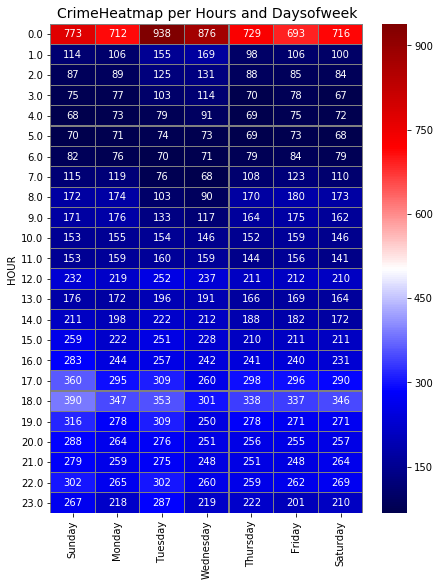

In [118]:
# Create a pivot table with day and month; another that counts the number of years that each day had; and the average. 
crimes_pivot_table = crime[(crime['Date'] != '2017-06-06')].pivot_table(values='YEAR', index='HOUR', columns='DayOfWeek', aggfunc=len)
crimes_pivot_table_year_count = crime[(crime['Date'] != '2017-06-06')].pivot_table(values='YEAR', index='HOUR', columns='DayOfWeek', aggfunc=lambda x: len(x.unique()))
crimes_average = crimes_pivot_table/crimes_pivot_table_year_count
crimes_average.columns = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
# Using seaborn heatmap
plt.figure(figsize=(7,9))
plt.title('CrimeHeatmap per Hours and Daysofweek', fontsize=14)
sns.heatmap(crimes_average.round(), cmap='seismic', linecolor='grey',linewidths=0.1, cbar=True, annot=True, fmt=".0f");
plt.show()

#Indicating hotspotmap of Vancouver City
We can't work with the full dataset as not all coordinates were logged correctly but we can still get a good idea which neighbourhoods are the crime hot-spots. Vancouver CBD being the most noticeable, Kitsilando, Kerrisdale, Sunset(South Vancouver) and Marpole.

In [119]:
#A seperate file named crime_heatmap.html is created and if we open that file we can observe the geo distribution of crime.
#gmplot:A matplotlib-like interface to generate the HTML
#and javascript to render all the data you’d like on top of Google Maps
import gmplot 
# Clean the data of zero points of latitude amd longitude 
#as we can not plot those coordinates
dfCoord = crime[(crime.Latitude != 0.0) & (crime.Longitude != 0.0)]

# Assign datapoints in variables
latitude = dfCoord["Latitude"]
longitude = dfCoord["Longitude"]

# Creating the location we would like to initialize the focus on. 
# Parameters: Lattitude, Longitude, Zoom
gmap = gmplot.GoogleMapPlotter(49.262, -123.135, 11)

# Overlay our datapoints onto the map
gmap.heatmap(latitude, longitude)

# Generate the heatmap into an HTML file
gmap.draw("crime_heatmap.html")

C:\Users\hites\Anaconda3\lib\site-packages\geopandas\plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
No handles with labels found to put in legend.


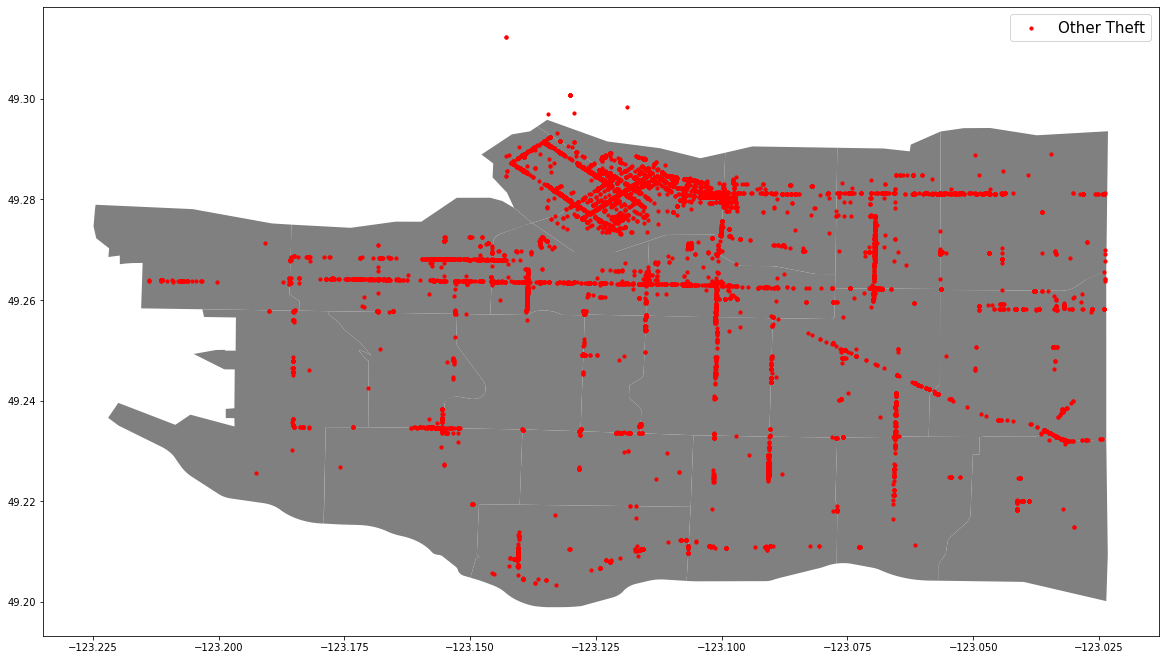

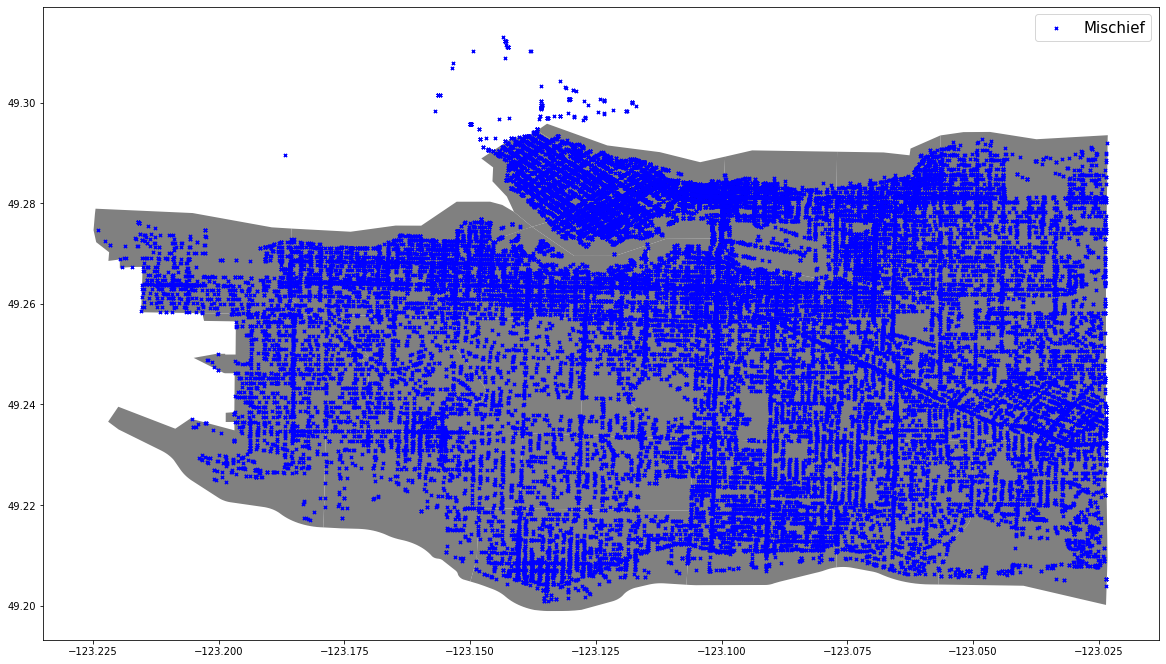

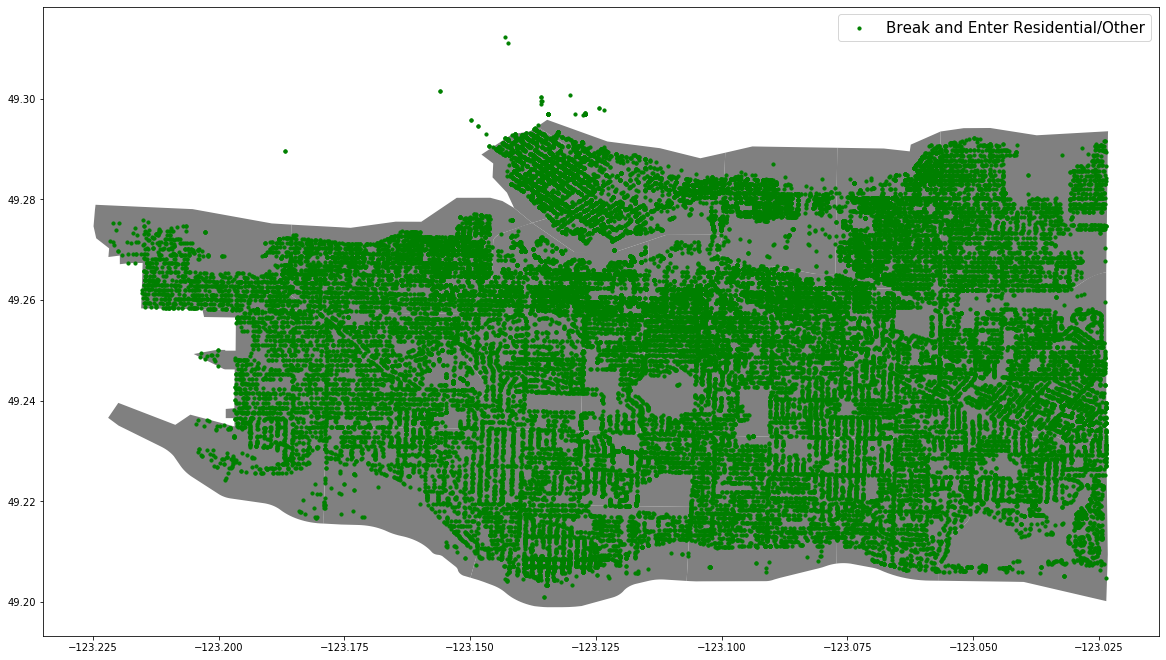

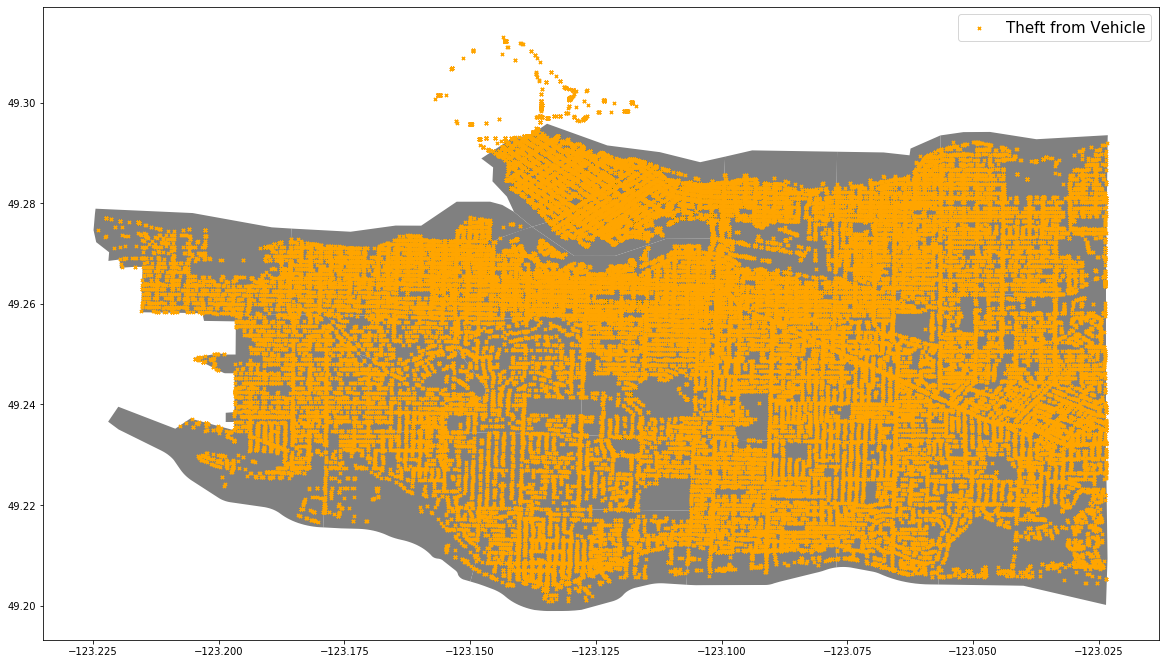

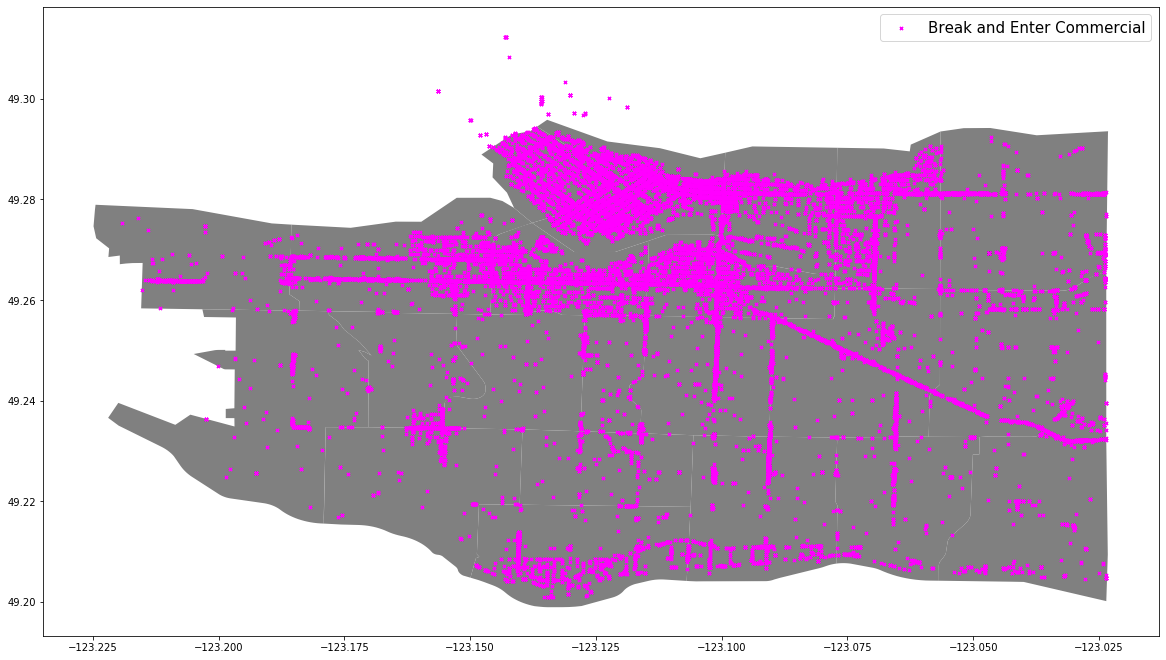

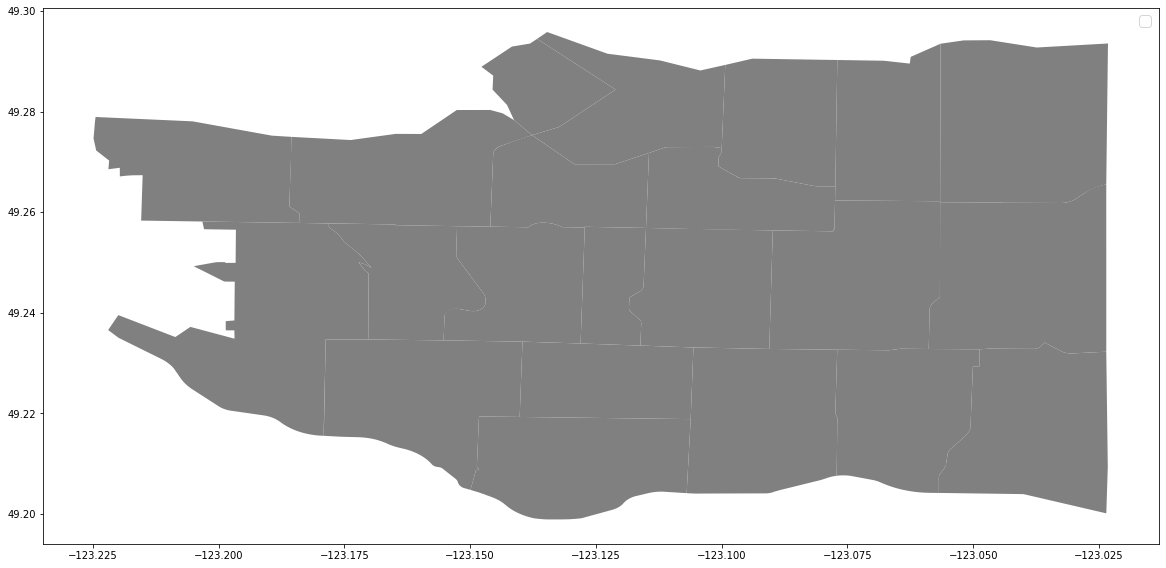

In [120]:
map = gpd.read_file("D:\PDF's\Western notes\Sem 2\Datasets for ML\Crime in Vancouver\VC_map\local-area-boundary.shp") #Opening the shape file for map data
sf=shp.Reader("D:\PDF's\Western notes\Sem 2\Datasets for ML\Crime in Vancouver\VC_map\local-area-boundary.shp")
data = pd.read_csv("crime.csv") #Reading dataset
crs = { 'init' : 'epsg:4326'} #European Petroleum survey group references every crs(Coordinate Reference system)
#data.head()
geometry = [Point(xy) for xy in zip(data["Longitude"],data["Latitude"])] #Creating Lattitude and Longitude for locations
geometry[:2]
geo_df = gpd.GeoDataFrame(data,crs = crs, geometry = geometry) #GeoDataFrame object is a pandas.DataFrame that has helps create the geometry and CRS
#geo_df.head()
fig,ax = plt.subplots(figsize =(20,15)) #Plotting the map for each 'TYPE' of crime.
map.plot(ax= ax, color = 'grey') #Color of map and axis
geo_df[geo_df['TYPE']=='Other Theft'].plot(ax = ax,markersize = 10, color = "red", marker = "o", label="Other Theft") #Sorting the 'TYPE' of crime- for plotting purposes
plt.legend(prop={'size':15}) #Plotting the map with the crime
#Plotting similar type of map for each type of crime
fig,ax = plt.subplots(figsize =(20,15))
map.plot(ax= ax, color = 'grey')
geo_df[geo_df['TYPE']=='Mischief'].plot(ax = ax,markersize = 10, color = "blue", marker = "x", label="Mischief")
plt.legend(prop={'size':15})
fig,ax = plt.subplots(figsize =(20,15))
map.plot(ax= ax, color = 'grey')
geo_df[geo_df['TYPE']=='Break and Enter Residential/Other'].plot(ax = ax,markersize = 10, color = "green", marker = "o", label="Break and Enter Residential/Other")
plt.legend(prop={'size':15})
fig,ax = plt.subplots(figsize =(20,15))
map.plot(ax= ax, color = 'grey')
geo_df[geo_df['TYPE']=='Theft from Vehicle'].plot(ax = ax,markersize = 10, color = "orange", marker = "x", label='Theft from Vehicle')
plt.legend(prop={'size':15})
fig,ax = plt.subplots(figsize =(20,15))
map.plot(ax= ax, color = 'grey')
geo_df[geo_df['TYPE']=='Break and Enter Commercial'].plot(ax = ax,markersize = 10, color = "magenta", marker = "x", label="Break and Enter Commercial")
plt.legend(prop={'size':15})
fig,ax = plt.subplots(figsize =(20,15))
map.plot(ax= ax, color = 'grey')
geo_df[geo_df['TYPE']=='Vehicle Collision or Pedestrian Struck(with injury)'].plot(ax = ax,markersize = 10, color = "yellow", marker = "x", label="Vehicle Collision or Pedestrian Struck(with injury)")
plt.legend(prop={'size':15})

In [121]:
#In similar way we convert HUNDRED_BLOCK and NEIGHBOURHOOD
crime['HUNDRED_BLOCK'] = encoder.fit_transform(crime['HUNDRED_BLOCK'])
crime['NEIGHBOURHOOD'] = encoder.fit_transform(crime['NEIGHBOURHOOD'])

In [122]:
crime.drop(columns = ['DayOfWeek','CATEGORY','Date','Incident'],inplace=True)

In [123]:
X = crime.iloc[:,1:].values   #Here X represents the features in our dataset
y = crime.iloc[:,:1].values   #Y represents the label which is "TYPE" in our dataset
print(crime.iloc[:,1:].head())
print(crime.iloc[:,:1].head())

            YEAR  MONTH  DAY  HOUR  HUNDRED_BLOCK  NEIGHBOURHOOD         X  \
Date                                                                         
2003-05-12  2003      5   12  16.0          14370             20  493906.5   
2003-05-07  2003      5    7  15.0          14370             20  493906.5   
2003-04-23  2003      4   23  16.0          14370             20  493906.5   
2003-04-20  2003      4   20  11.0          14370             20  493906.5   
2003-04-12  2003      4   12  17.0          14370             20  493906.5   

                     Y   Latitude   Longitude  
Date                                           
2003-05-12  5457452.47  49.269802 -123.083763  
2003-05-07  5457452.47  49.269802 -123.083763  
2003-04-23  5457452.47  49.269802 -123.083763  
2003-04-20  5457452.47  49.269802 -123.083763  
2003-04-12  5457452.47  49.269802 -123.083763  
            TYPE
Date            
2003-05-12     5
2003-05-07     5
2003-04-23     5
2003-04-20     5
2003-04-12     

In [124]:
# In the next few cells we will be classifying the datasets using various algorithms such as KNN, Naive_Bayes, Random Forest
# and MLP. We also use principal component analysis but this is applied only to KNN. The remaining algorithms deals with 
#original dataset(pca is not applied)

In [125]:
# Spliting the features and labels into training and testing sets. Training set contains 80% of the dataset
#whereas testing set has 20% of the dataset.
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size= 0.2,random_state = 1)

In [126]:
#Converting the test and train sets into dataFrames
X_train_df=pd.DataFrame(X_train)
X_test_df=pd.DataFrame(X_test)
y_train_df=pd.DataFrame(y_train)
y_test_df=pd.DataFrame(y_test)
print(X_train_df.head())

        0    1     2     3        4     5          6           7          8  \
0  2007.0  5.0  20.0   4.0  13231.0   3.0  491162.03  5457103.61  49.266630   
1  2005.0  1.0  14.0  22.0   5072.0   6.0  495347.78  5456400.98  49.260356   
2  2007.0  5.0  30.0   0.0  19076.0  13.0       0.00        0.00   0.000000   
3  2003.0  3.0   7.0  19.0  11988.0  11.0  492463.31  5457080.01  49.266436   
4  2007.0  2.0  27.0   7.0  18310.0   6.0  494442.00  5454478.00  49.243051   

            9  
0 -123.121482  
1 -123.063939  
2    0.000000  
3 -123.103595  
4 -123.076361  


In [127]:
#Applying principal Component analysis to reduce the dimentionality of the features
pca1=decomposition.PCA(n_components=3)

In [128]:
#Fitting the features using pca
pca1.fit(X)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [129]:
x_transformed=pca1.transform(X)

In [130]:
x_transformed_df=pd.DataFrame(x_transformed)
y_df=pd.DataFrame(y)

In [131]:
#Displaying the modified feature dataset
PCA_dataset = pd.concat([x_transformed_df,y_df], axis = 1)
PCA_dataset.columns=['PCA_Feature_1', 'PCA_Feature_2','PCA_Feature_3', 'Label']
print(PCA_dataset.head(100))

    PCA_Feature_1  PCA_Feature_2  PCA_Feature_3  Label
0   -5.621954e+05    6395.684800   -1471.686624      5
1   -5.621954e+05    6395.684763   -1471.686600      5
2   -5.621954e+05    6395.684863   -1471.686658      5
3   -5.621954e+05    6395.684817   -1471.686624      5
4   -5.621954e+05    6395.684799   -1471.686618      5
5   -5.621954e+05    6395.684898   -1471.686677      5
6   -5.571739e+05    3383.957553    2614.030534      1
7   -5.599260e+05     281.336423    6235.870928      3
8   -5.621954e+05    6395.684769   -1471.686581      5
9   -5.620949e+05   -5665.934565   -2904.588508      1
10  -5.621954e+05    6395.684912   -1471.686673      5
11  -5.597226e+05     282.275676    6267.886088      3
12  -5.621052e+05   -5665.616594   -2919.220113      1
13  -5.620968e+05   -5665.411596   -2930.141935      1
14  -5.573888e+05    3476.018754   -1848.671237      1
15  -5.636244e+05   -8020.934509    1212.819866      0
16  -5.621071e+05   -5665.093727   -2944.773493      1
17  -5.621

In [132]:
#Applying randomforest classifier on the unmodified(feature data with no pca) feature dataset and label set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train,y_train)

C:\Users\hites\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\hites\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [133]:
#Determining the accuracy and F1-score of the random forest classifier
from sklearn.metrics import accuracy_score
from sklearn import metrics 
y_predict = classifier.predict(X_test)
print('Accuracy of Random Forest Classifier is:',accuracy_score(y_test,y_predict)*100)
print(metrics.classification_report(y_test,y_predict))

Accuracy of Random Forest Classifier is: 54.52412584447522
              precision    recall  f1-score   support

           0       0.40      0.40      0.40      6732
           1       0.39      0.44      0.41     12086
           2       0.00      0.00      0.00        48
           3       0.28      0.25      0.26     14025
           4       1.00      1.00      1.00     10854
           5       0.83      0.86      0.85     10471
           6       0.53      0.64      0.58     34598
           7       0.32      0.16      0.22      5177
           8       0.22      0.11      0.14      7743
           9       0.00      0.00      0.00        50
          10       0.79      0.61      0.69      4347

   micro avg       0.55      0.55      0.55    106131
   macro avg       0.43      0.41      0.41    106131
weighted avg       0.53      0.55      0.53    106131



C:\Users\hites\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [134]:
#Applying Naive_Bayes Classifier on the dataset( Unmodified features and labels)
from sklearn.naive_bayes import GaussianNB
classifier1 = GaussianNB()
classifier1.fit(X_train,y_train)

C:\Users\hites\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB(priors=None, var_smoothing=1e-09)

In [135]:
#Predicting the accuracy obtained from the naive bayes classifier
y_predict=classifier1.predict(X_test)
print('Accuracy of Naive Bayes algorithm is:',accuracy_score(y_test,y_predict)*100)

Accuracy of Naive Bayes algorithm is: 41.99432776474357


In [136]:
#Considering KNN classifier
from sklearn.neighbors import KNeighborsClassifier

In [137]:
# The KNN classifier has n_neighbors set to 4, md1 is used to work on unmodified features and labels
#whereas md2 deals with pca features.
md1 = KNeighborsClassifier(n_neighbors = 4)
md2 = KNeighborsClassifier(n_neighbors = 4)

In [138]:
from sklearn.model_selection import train_test_split

In [139]:
#Spliting the test and train sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.20, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(x_transformed_df, y, test_size=0.20, random_state=42)

In [140]:
#Fitting the model and predicting the outputs 
md2.fit(X_train2,y_train2)
md1.fit(X_train1,y_train1)
predict = md1.predict(X_test1)
predict2 = md2.predict(X_test2)

C:\Users\hites\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
C:\Users\hites\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [141]:
#Finding the scores of KNN on original data(score1) and on pca dataset(score2) 
score1 = md1.score(X_test1,y_test1)
score2 = md2.score(X_test2,y_test2)

In [142]:
#Calculating the accuracies 
print('Accuracy of KNN algorithm on original features is:',score1)
print(metrics.classification_report(y_test1,predict))

Accuracy of KNN algorithm on original features is: 0.5406149004532135
              precision    recall  f1-score   support

           0       0.37      0.46      0.41      6782
           1       0.38      0.51      0.44     12237
           2       0.00      0.00      0.00        49
           3       0.28      0.24      0.26     13985
           4       1.00      1.00      1.00     10975
           5       0.81      0.87      0.84     10415
           6       0.54      0.59      0.57     34450
           7       0.30      0.14      0.19      5196
           8       0.24      0.11      0.15      7635
           9       0.00      0.00      0.00        40
          10       0.77      0.59      0.67      4367

   micro avg       0.54      0.54      0.54    106131
   macro avg       0.42      0.41      0.41    106131
weighted avg       0.53      0.54      0.53    106131



C:\Users\hites\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train2,y_train2)

In [143]:
#printing the accuracies of KNN on the pca dataset
print('Accuracy of KNN algorithm on transformed features is:',score2)
print(metrics.classification_report(y_test2,predict2))

Accuracy of KNN algorithm on transformed features is: 0.5501408636496405
              precision    recall  f1-score   support

           0       0.37      0.49      0.42      6782
           1       0.39      0.50      0.44     12237
           2       0.00      0.00      0.00        49
           3       0.29      0.24      0.26     13985
           4       1.00      1.00      1.00     10975
           5       0.82      0.87      0.85     10415
           6       0.55      0.60      0.57     34450
           7       0.32      0.15      0.20      5196
           8       0.25      0.12      0.16      7635
           9       0.00      0.00      0.00        40
          10       0.88      0.69      0.78      4367

   micro avg       0.55      0.55      0.55    106131
   macro avg       0.44      0.42      0.43    106131
weighted avg       0.54      0.55      0.54    106131



In [144]:
from sklearn.neural_network import MLPClassifier
model1=MLPClassifier(hidden_layer_sizes=(10,10,10),activation='logistic',alpha=0.001,learning_rate_init=0.001,max_iter=300)
#model2=MLPClassifier(hidden_layer_sizes=(10,10,10),activation='logistic',alpha=0.001,learning_rate_init=0.001,max_iter=300)
model1.fit(X_train1,y_train1)
#model2.fit(X_train2,y_train2)
predict1=model1.predict(X_test1)
#predict2=model2.predict(X_test2)
print('The accuracy of MLP algorithm is:',accuracy_score(y_test1,predict1))
print(metrics.classification_report(y_test1,predict1))

C:\Users\hites\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:916: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy of MLP algorithm is: 0.428008781600098
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6782
           1       0.00      0.00      0.00     12237
           2       0.00      0.00      0.00        49
           3       0.00      0.00      0.00     13985
           4       1.00      1.00      1.00     10975
           5       0.00      0.00      0.00     10415
           6       0.36      1.00      0.53     34450
           7       0.00      0.00      0.00      5196
           8       0.00      0.00      0.00      7635
           9       0.00      0.00      0.00        40
          10       0.00      0.00      0.00      4367

   micro avg       0.43      0.43      0.43    106131
   macro avg       0.12      0.18      0.14    106131
weighted avg       0.22      0.43      0.28    106131



C:\Users\hites\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
